In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [4]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


In [0]:
def load_data(data_path: str, test_size=0.2, random_state=42, info=False):
    """Load data from file.
    
    Args:
        data_path: str, file path to read data
        test_size: float, the ratio of test / all
        random_state: int, random seed to split data
        info: bool, control info print
    Returns:
        train_data: np.array, train set
        test_data: np.array, test set
    """
    # imgs = [np.array(Image.open(d)) for d in Path(data_path).iterdir()]
    imgs = []
    for d in Path(data_path).iterdir():
        if info:
            print('Load image: ' + d.name)
        imgs.append(np.array(Image.open(d)))
    data = np.array(imgs)
    train_data, test_data = train_test_split(
        data, test_size=test_size, random_state=random_state)
    return train_data, test_data

In [0]:
def load_label(label_path: str, test_size=0.2, random_state=42):
    """Load label from file.
    
    Args:
        label_path: str, file path to read label
        test_size: float, the ratio of test / all, 
            this arg should match up test_size in load_data
        random_state: int, random seed to split data
            this arg should match up random_state in load_data
    """
    with open(label_path, 'r') as f:
        labels = f.readline()
    train_label, test_label = train_test_split(
        labels.split('\t'), test_size=test_size, random_state=random_state)
    le = LabelEncoder()
    le.fit(train_label)
    return le.transform(train_label), le.transform(test_label)

In [0]:
train_label, test_label = load_label('./drive/data/FacePlace/AsianSample.txt')

In [35]:
train_data, test_data = load_data('./drive/data/FacePlace/AsianSample/', info=True)

Load image: AM0302_1100_60L.jpg
Load image: AM0302_1100_30L.jpg
Load image: AM0302_1100_45L.jpg
Load image: AM0302_1100_45R.jpg
Load image: AM0302_1100_DI.jpg
Load image: AM0302_1100_HA.jpg
Load image: AM0302_1100_SU.jpg
Load image: AM0302_1100_NE.jpg
Load image: AM0302_2201_30L.jpg
Load image: AM0302_1100_SA.jpg
Load image: AM0302_2201_00F.jpg
Load image: AM0302_2201_45L.jpg
Load image: AM0302_2201_45R.jpg
Load image: AM0302_2201_30R.jpg
Load image: AM0302_2201_60L.jpg
Load image: AM0302_2201_90L.jpg
Load image: AM0303_1100_30L.jpg
Load image: AM0303_1100_00F.jpg
Load image: AM0302_2201_90R.jpg
Load image: AM0302_2201_NE.jpg
Load image: AM0303_1100_45R.jpg
Load image: AM0302_2201_60R.jpg
Load image: AM0303_1100_45L.jpg
Load image: AM0303_1100_30R.jpg
Load image: AM0303_1100_60L.jpg
Load image: AM0303_1100_HA.jpg
Load image: AM0303_2201_00F.jpg
Load image: AM0303_1100_NE.jpg
Load image: AM0303_1100_60R.jpg
Load image: AM0303_1100_DI.jpg
Load image: AM0303_1100_SA.jpg
Load image: AM0303

In [0]:
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
train_label, val_label = train_test_split(train_label, test_size=0.1, random_state=42)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # randomly flip images
datagen.fit(train_data)

In [0]:
def vanilia_cnn(input_shape: tuple, classes: int):
    """Implement vanilla ConvNet model."""
    model = models.Sequential()
    model.add(
        layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same',
                      input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [41]:
model = vanilia_cnn(input_shape=train_data[0].shape, classes=train_label.max() + 1)
history = model.fit_generator(
    datagen.flow(train_data, train_label, batch_size=32),
    epochs=200, validation_data=(val_data, val_label))

# epochs = 100

# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(train_data, train_label, batch_size=10):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= len(train_data):
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break
#         model.evaluate(val_data, val_label)

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 2.4458 - acc: 0.1006 - val_loss: 2.2987 - val_acc: 0.1818
Epoch 2/200
6/6 [==============================] - 4s 712ms/step - loss: 2.3048 - acc: 0.0957 - val_loss: 2.2943 - val_acc: 0.1364
Epoch 3/200
6/6 [==============================] - 4s 714ms/step - loss: 2.2919 - acc: 0.1313 - val_loss: 2.2767 - val_acc: 0.1818
Epoch 4/200
6/6 [==============================] - 4s 714ms/step - loss: 2.2612 - acc: 0.1165 - val_loss: 2.2990 - val_acc: 0.1364
Epoch 5/200
6/6 [==============================] - 4s 713ms/step - loss: 2.2664 - acc: 0.1374 - val_loss: 2.2670 - val_acc: 0.2273
Epoch 6/200
6/6 [==============================] - 4s 712ms/step - loss: 2.1837 - acc: 0.1264 - val_loss: 2.2385 - val_acc: 0.1364
Epoch 7/200
6/6 [==============================] - 4s 713ms/step - loss: 2.1194 - acc: 0.2528 - val_loss: 2.3847 - val_acc: 0.1818
Epoch 8/200
6/6 [==============================] - 4s 707ms/step - loss: 2.1662 - acc

6/6 [==============================] - 4s 713ms/step - loss: 1.8729 - acc: 0.3687 - val_loss: 2.5877 - val_acc: 0.0909
Epoch 16/200
6/6 [==============================] - 4s 710ms/step - loss: 1.8679 - acc: 0.3623 - val_loss: 2.3662 - val_acc: 0.0909
Epoch 17/200
6/6 [==============================] - 4s 715ms/step - loss: 1.7099 - acc: 0.4061 - val_loss: 2.4595 - val_acc: 0.0909
Epoch 18/200
6/6 [==============================] - 4s 715ms/step - loss: 1.7250 - acc: 0.4012 - val_loss: 2.7158 - val_acc: 0.0909
Epoch 19/200
6/6 [==============================] - 4s 715ms/step - loss: 1.7319 - acc: 0.4313 - val_loss: 2.3274 - val_acc: 0.0909
Epoch 20/200
6/6 [==============================] - 4s 705ms/step - loss: 1.6856 - acc: 0.4368 - val_loss: 2.4913 - val_acc: 0.0909
Epoch 21/200
6/6 [==============================] - 4s 710ms/step - loss: 1.6549 - acc: 0.4359 - val_loss: 2.2480 - val_acc: 0.1818
Epoch 22/200
6/6 [==============================] - 4s 712ms/step - loss: 1.5882 - acc: 0

6/6 [==============================] - 4s 709ms/step - loss: 1.1398 - acc: 0.5429 - val_loss: 5.6351 - val_acc: 0.3182
Epoch 30/200
6/6 [==============================] - 4s 715ms/step - loss: 0.9901 - acc: 0.6536 - val_loss: 6.4438 - val_acc: 0.1818
Epoch 31/200
6/6 [==============================] - 4s 713ms/step - loss: 1.1943 - acc: 0.5829 - val_loss: 5.7957 - val_acc: 0.2273
Epoch 32/200
6/6 [==============================] - 4s 713ms/step - loss: 0.9779 - acc: 0.5844 - val_loss: 6.5643 - val_acc: 0.1364
Epoch 33/200
6/6 [==============================] - 4s 714ms/step - loss: 0.8536 - acc: 0.6838 - val_loss: 7.2991 - val_acc: 0.1364
Epoch 34/200
6/6 [==============================] - 4s 714ms/step - loss: 0.7777 - acc: 0.7098 - val_loss: 7.5615 - val_acc: 0.0909
Epoch 35/200
6/6 [==============================] - 4s 711ms/step - loss: 0.8665 - acc: 0.6632 - val_loss: 7.1574 - val_acc: 0.0909
Epoch 36/200
6/6 [==============================] - 4s 711ms/step - loss: 0.7434 - acc: 0

6/6 [==============================] - 4s 712ms/step - loss: 0.6965 - acc: 0.7525 - val_loss: 6.8122 - val_acc: 0.0455
Epoch 44/200
6/6 [==============================] - 4s 710ms/step - loss: 0.7178 - acc: 0.7838 - val_loss: 4.6536 - val_acc: 0.1818
Epoch 45/200
6/6 [==============================] - 4s 715ms/step - loss: 0.6660 - acc: 0.7791 - val_loss: 4.5593 - val_acc: 0.0909
Epoch 46/200
6/6 [==============================] - 4s 714ms/step - loss: 0.4584 - acc: 0.8466 - val_loss: 7.1502 - val_acc: 0.0909
Epoch 47/200
6/6 [==============================] - 4s 711ms/step - loss: 0.5253 - acc: 0.7945 - val_loss: 5.5526 - val_acc: 0.0909
Epoch 48/200
6/6 [==============================] - 4s 713ms/step - loss: 0.4538 - acc: 0.8310 - val_loss: 5.2885 - val_acc: 0.1364
Epoch 49/200
6/6 [==============================] - 4s 713ms/step - loss: 0.4389 - acc: 0.8528 - val_loss: 4.7572 - val_acc: 0.0909
Epoch 50/200
6/6 [==============================] - 4s 714ms/step - loss: 0.5169 - acc: 0

6/6 [==============================] - 4s 712ms/step - loss: 0.4525 - acc: 0.8322 - val_loss: 8.4593 - val_acc: 0.1364
Epoch 58/200
6/6 [==============================] - 4s 716ms/step - loss: 0.4472 - acc: 0.8635 - val_loss: 8.2014 - val_acc: 0.0909
Epoch 59/200
6/6 [==============================] - 4s 714ms/step - loss: 0.4588 - acc: 0.8577 - val_loss: 9.9361 - val_acc: 0.0455
Epoch 60/200
6/6 [==============================] - 4s 712ms/step - loss: 0.3442 - acc: 0.8638 - val_loss: 9.1447 - val_acc: 0.0455
Epoch 61/200
6/6 [==============================] - 4s 711ms/step - loss: 0.4988 - acc: 0.8104 - val_loss: 10.7282 - val_acc: 0.0455
Epoch 62/200
6/6 [==============================] - 4s 710ms/step - loss: 0.4600 - acc: 0.8632 - val_loss: 8.5166 - val_acc: 0.0455
Epoch 63/200
6/6 [==============================] - 4s 708ms/step - loss: 0.3256 - acc: 0.9000 - val_loss: 8.6162 - val_acc: 0.0455
Epoch 64/200
6/6 [==============================] - 4s 716ms/step - loss: 0.4171 - acc: 

6/6 [==============================] - 4s 708ms/step - loss: 0.3896 - acc: 0.8730 - val_loss: 7.0727 - val_acc: 0.0909
Epoch 72/200
6/6 [==============================] - 4s 713ms/step - loss: 0.4881 - acc: 0.8466 - val_loss: 10.1315 - val_acc: 0.1364
Epoch 73/200
6/6 [==============================] - 4s 713ms/step - loss: 0.6249 - acc: 0.7896 - val_loss: 7.4557 - val_acc: 0.0909
Epoch 74/200
6/6 [==============================] - 4s 715ms/step - loss: 0.5006 - acc: 0.8727 - val_loss: 8.4059 - val_acc: 0.1364
Epoch 75/200
6/6 [==============================] - 4s 715ms/step - loss: 0.3668 - acc: 0.8583 - val_loss: 6.7985 - val_acc: 0.1364
Epoch 76/200
6/6 [==============================] - 4s 716ms/step - loss: 0.2402 - acc: 0.9104 - val_loss: 7.9261 - val_acc: 0.1364
Epoch 77/200
6/6 [==============================] - 4s 712ms/step - loss: 0.2755 - acc: 0.9055 - val_loss: 9.5461 - val_acc: 0.0909
Epoch 78/200
6/6 [==============================] - 4s 715ms/step - loss: 0.2685 - acc: 

6/6 [==============================] - 4s 712ms/step - loss: 0.3043 - acc: 0.8884 - val_loss: 7.1681 - val_acc: 0.0909
Epoch 86/200
6/6 [==============================] - 4s 733ms/step - loss: 0.1899 - acc: 0.9368 - val_loss: 8.6997 - val_acc: 0.1364
Epoch 87/200
6/6 [==============================] - 4s 736ms/step - loss: 0.2412 - acc: 0.9156 - val_loss: 8.9151 - val_acc: 0.0909
Epoch 88/200
6/6 [==============================] - 4s 727ms/step - loss: 0.2181 - acc: 0.9003 - val_loss: 10.2107 - val_acc: 0.0909
Epoch 89/200
6/6 [==============================] - 4s 733ms/step - loss: 0.1474 - acc: 0.9420 - val_loss: 10.2909 - val_acc: 0.0909
Epoch 90/200
6/6 [==============================] - 4s 726ms/step - loss: 0.2148 - acc: 0.9264 - val_loss: 9.6930 - val_acc: 0.0909
Epoch 91/200
6/6 [==============================] - 4s 720ms/step - loss: 0.2134 - acc: 0.9058 - val_loss: 10.2496 - val_acc: 0.0909
Epoch 92/200
6/6 [==============================] - 4s 728ms/step - loss: 0.1751 - acc

6/6 [==============================] - 4s 723ms/step - loss: 0.1847 - acc: 0.9261 - val_loss: 8.8478 - val_acc: 0.0909
Epoch 100/200
6/6 [==============================] - 4s 714ms/step - loss: 0.2143 - acc: 0.9316 - val_loss: 8.2548 - val_acc: 0.1364
Epoch 101/200
6/6 [==============================] - 4s 724ms/step - loss: 0.1507 - acc: 0.9525 - val_loss: 7.2562 - val_acc: 0.1364
Epoch 102/200
6/6 [==============================] - 4s 720ms/step - loss: 0.1719 - acc: 0.9417 - val_loss: 8.0213 - val_acc: 0.1364
Epoch 103/200
6/6 [==============================] - 4s 721ms/step - loss: 0.2819 - acc: 0.8779 - val_loss: 6.8517 - val_acc: 0.2273
Epoch 104/200
6/6 [==============================] - 4s 719ms/step - loss: 0.1785 - acc: 0.9417 - val_loss: 6.6697 - val_acc: 0.1818
Epoch 105/200
6/6 [==============================] - 4s 724ms/step - loss: 0.1602 - acc: 0.9577 - val_loss: 8.0644 - val_acc: 0.1818
Epoch 106/200
6/6 [==============================] - 4s 716ms/step - loss: 0.1527 -

6/6 [==============================] - 4s 724ms/step - loss: 0.1930 - acc: 0.9113 - val_loss: 10.1685 - val_acc: 0.0909
Epoch 114/200
6/6 [==============================] - 4s 710ms/step - loss: 0.2071 - acc: 0.9417 - val_loss: 8.0293 - val_acc: 0.1364
Epoch 115/200
6/6 [==============================] - 4s 717ms/step - loss: 0.1796 - acc: 0.9423 - val_loss: 9.3829 - val_acc: 0.0909
Epoch 116/200
6/6 [==============================] - 4s 718ms/step - loss: 0.1828 - acc: 0.9154 - val_loss: 9.7114 - val_acc: 0.0909
Epoch 117/200
6/6 [==============================] - 4s 716ms/step - loss: 0.1335 - acc: 0.9632 - val_loss: 9.1214 - val_acc: 0.1364
Epoch 118/200
6/6 [==============================] - 4s 713ms/step - loss: 0.1571 - acc: 0.9313 - val_loss: 9.5513 - val_acc: 0.1364
Epoch 119/200
6/6 [==============================] - 4s 716ms/step - loss: 0.2168 - acc: 0.9374 - val_loss: 9.3104 - val_acc: 0.1364
Epoch 120/200
6/6 [==============================] - 4s 710ms/step - loss: 0.1956 

6/6 [==============================] - 4s 735ms/step - loss: 0.1700 - acc: 0.9264 - val_loss: 10.0636 - val_acc: 0.2273
Epoch 128/200
6/6 [==============================] - 4s 712ms/step - loss: 0.1701 - acc: 0.9420 - val_loss: 8.6286 - val_acc: 0.1818
Epoch 129/200
6/6 [==============================] - 4s 715ms/step - loss: 0.1145 - acc: 0.9414 - val_loss: 7.9047 - val_acc: 0.1818
Epoch 130/200
6/6 [==============================] - 4s 712ms/step - loss: 0.1549 - acc: 0.9531 - val_loss: 9.0464 - val_acc: 0.0909
Epoch 131/200
6/6 [==============================] - 4s 713ms/step - loss: 0.1788 - acc: 0.9371 - val_loss: 8.7507 - val_acc: 0.0909
Epoch 132/200
6/6 [==============================] - 4s 714ms/step - loss: 0.0909 - acc: 0.9583 - val_loss: 9.1740 - val_acc: 0.1364
Epoch 133/200
6/6 [==============================] - 4s 713ms/step - loss: 0.1339 - acc: 0.9478 - val_loss: 9.4792 - val_acc: 0.1818
Epoch 134/200
6/6 [==============================] - 4s 714ms/step - loss: 0.1068 

6/6 [==============================] - 4s 710ms/step - loss: 0.1233 - acc: 0.9583 - val_loss: 9.6568 - val_acc: 0.1364
Epoch 142/200
6/6 [==============================] - 4s 711ms/step - loss: 0.1857 - acc: 0.9267 - val_loss: 10.5452 - val_acc: 0.1818
Epoch 143/200
6/6 [==============================] - 4s 713ms/step - loss: 0.1646 - acc: 0.9417 - val_loss: 10.5578 - val_acc: 0.1364
Epoch 144/200
6/6 [==============================] - 4s 714ms/step - loss: 0.2080 - acc: 0.9261 - val_loss: 10.5906 - val_acc: 0.0909
Epoch 145/200
6/6 [==============================] - 4s 712ms/step - loss: 0.1027 - acc: 0.9580 - val_loss: 10.4973 - val_acc: 0.0909
Epoch 146/200
6/6 [==============================] - 4s 716ms/step - loss: 0.1006 - acc: 0.9841 - val_loss: 10.4894 - val_acc: 0.1364
Epoch 147/200
6/6 [==============================] - 4s 715ms/step - loss: 0.0818 - acc: 0.9736 - val_loss: 10.2771 - val_acc: 0.1364
Epoch 148/200
6/6 [==============================] - 4s 713ms/step - loss: 0.

6/6 [==============================] - 4s 714ms/step - loss: 0.0848 - acc: 0.9739 - val_loss: 8.7166 - val_acc: 0.1818
Epoch 156/200
6/6 [==============================] - 4s 711ms/step - loss: 0.1911 - acc: 0.9420 - val_loss: 10.2969 - val_acc: 0.1364
Epoch 157/200
6/6 [==============================] - 4s 713ms/step - loss: 0.1868 - acc: 0.9316 - val_loss: 9.5423 - val_acc: 0.1364
Epoch 158/200
6/6 [==============================] - 4s 715ms/step - loss: 0.0901 - acc: 0.9736 - val_loss: 8.4303 - val_acc: 0.1364
Epoch 159/200
6/6 [==============================] - 4s 710ms/step - loss: 0.0971 - acc: 0.9577 - val_loss: 9.5621 - val_acc: 0.0909
Epoch 160/200
6/6 [==============================] - 4s 707ms/step - loss: 0.1358 - acc: 0.9528 - val_loss: 10.1605 - val_acc: 0.0455
Epoch 161/200
6/6 [==============================] - 4s 711ms/step - loss: 0.0638 - acc: 0.9684 - val_loss: 10.2794 - val_acc: 0.0909
Epoch 162/200
6/6 [==============================] - 4s 713ms/step - loss: 0.100

6/6 [==============================] - 4s 713ms/step - loss: 0.1160 - acc: 0.9580 - val_loss: 8.5035 - val_acc: 0.1364
Epoch 170/200
6/6 [==============================] - 4s 711ms/step - loss: 0.0691 - acc: 0.9736 - val_loss: 8.4781 - val_acc: 0.1818
Epoch 171/200
6/6 [==============================] - 4s 710ms/step - loss: 0.1197 - acc: 0.9478 - val_loss: 7.6455 - val_acc: 0.1818
Epoch 172/200
6/6 [==============================] - 4s 711ms/step - loss: 0.0920 - acc: 0.9739 - val_loss: 7.2598 - val_acc: 0.1818
Epoch 173/200
6/6 [==============================] - 4s 715ms/step - loss: 0.0939 - acc: 0.9687 - val_loss: 6.9935 - val_acc: 0.0909
Epoch 174/200
6/6 [==============================] - 4s 711ms/step - loss: 0.1157 - acc: 0.9580 - val_loss: 5.8959 - val_acc: 0.1364
Epoch 175/200
6/6 [==============================] - 4s 708ms/step - loss: 0.0944 - acc: 0.9687 - val_loss: 6.4889 - val_acc: 0.1818
Epoch 176/200
6/6 [==============================] - 4s 713ms/step - loss: 0.0745 -

6/6 [==============================] - 4s 712ms/step - loss: 0.0594 - acc: 0.9739 - val_loss: 11.3527 - val_acc: 0.0909
Epoch 184/200
6/6 [==============================] - 4s 716ms/step - loss: 0.0862 - acc: 0.9684 - val_loss: 10.7269 - val_acc: 0.0455
Epoch 185/200
6/6 [==============================] - 4s 713ms/step - loss: 0.1535 - acc: 0.9632 - val_loss: 10.3073 - val_acc: 0.0909
Epoch 186/200
6/6 [==============================] - 4s 713ms/step - loss: 0.0834 - acc: 0.9736 - val_loss: 10.1264 - val_acc: 0.0909
Epoch 187/200
6/6 [==============================] - 4s 712ms/step - loss: 0.1046 - acc: 0.9525 - val_loss: 9.5244 - val_acc: 0.0909
Epoch 188/200
6/6 [==============================] - 4s 712ms/step - loss: 0.0507 - acc: 0.9844 - val_loss: 9.9675 - val_acc: 0.0909
Epoch 189/200
6/6 [==============================] - 4s 712ms/step - loss: 0.0475 - acc: 0.9841 - val_loss: 9.4535 - val_acc: 0.0909
Epoch 190/200
6/6 [==============================] - 4s 711ms/step - loss: 0.12

6/6 [==============================] - 4s 713ms/step - loss: 0.0537 - acc: 0.9739 - val_loss: 10.4115 - val_acc: 0.0909
Epoch 198/200
6/6 [==============================] - 4s 716ms/step - loss: 0.1292 - acc: 0.9684 - val_loss: 11.5284 - val_acc: 0.0909
Epoch 199/200
6/6 [==============================] - 4s 709ms/step - loss: 0.0752 - acc: 0.9788 - val_loss: 10.8426 - val_acc: 0.1364
Epoch 200/200
6/6 [==============================] - 4s 711ms/step - loss: 0.1451 - acc: 0.9472 - val_loss: 9.7153 - val_acc: 0.0909


In [0]:
model.save('./drive/asian_vanilia3.h5')

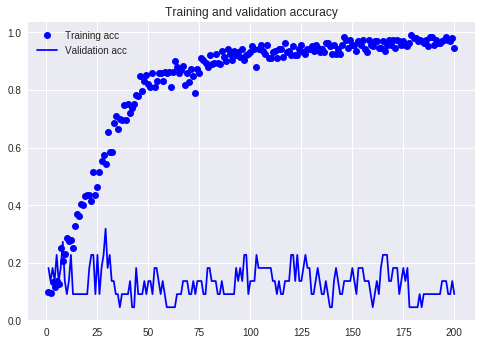

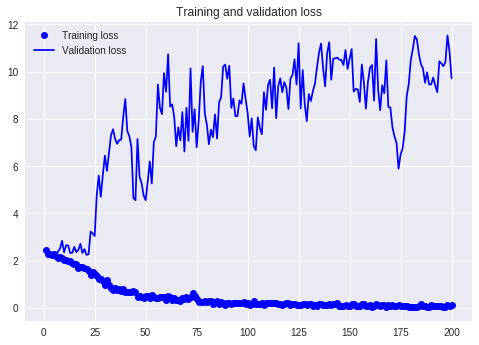

In [43]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
model.evaluate(test_data, test_label)

54/54 [==============================] - 0s 9ms/step


[10.237989178410283, 0.07407407462596893]

In [0]:
def vanilia_cnn(input_shape: tuple, classes: int):
    """Implement vanilla ConvNet model."""
    model = models.Sequential()
    model.add(
        layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same',
                      input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation='softmax'))

    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [9]:
input_shape = (250, 250, 3)
classes = 10



train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  # This is the target directory
  './drive/data/FacePlace/AsianSample/train',
  target_size=(250, 250),
  batch_size=32,
  # Since we use binary_crossentropy loss, we need binary labels
  class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
  './drive/data/FacePlace/AsianSample/val',
  target_size=(250, 250),
  batch_size=32,
  class_mode='categorical')

model = vanilia_cnn(input_shape=input_shape, classes=classes)

history = model.fit_generator(
  train_generator,
  steps_per_epoch=50,
  epochs=300,
  validation_data=validation_generator,
  validation_steps=50)

Found 236 images belonging to 10 classes.
Found 20 images belonging to 10 classes.
Epoch 1/100
50/50 [==============================] - 227s 5s/step - loss: 2.2968 - acc: 0.1346 - val_loss: 2.3010 - val_acc: 0.1000
Epoch 2/100
50/50 [==============================] - 52s 1s/step - loss: 2.2906 - acc: 0.1396 - val_loss: 2.3003 - val_acc: 0.2000
Epoch 3/100
50/50 [==============================] - 50s 1s/step - loss: 2.2824 - acc: 0.1554 - val_loss: 2.2976 - val_acc: 0.2000
Epoch 4/100
50/50 [==============================] - 54s 1s/step - loss: 2.2755 - acc: 0.1702 - val_loss: 2.2905 - val_acc: 0.2000
Epoch 5/100
34/50 [===================>..........] - ETA: 13s - loss: 2.2691 - acc: 0.1805

50/50 [==============================] - 52s 1s/step - loss: 2.2669 - acc: 0.1812 - val_loss: 2.2877 - val_acc: 0.1000
Epoch 6/100
50/50 [==============================] - 52s 1s/step - loss: 2.2653 - acc: 0.1784 - val_loss: 2.2757 - val_acc: 0.1000
Epoch 7/100
50/50 [==============================] - 51s 1s/step - loss: 2.2430 - acc: 0.1908 - val_loss: 2.2563 - val_acc: 0.2000
Epoch 8/100
50/50 [==============================] - 54s 1s/step - loss: 2.2236 - acc: 0.1935 - val_loss: 2.2779 - val_acc: 0.2000
Epoch 9/100
50/50 [==============================] - 52s 1s/step - loss: 2.2234 - acc: 0.1792 - val_loss: 2.2683 - val_acc: 0.2000
Epoch 10/100
21/50 [===========>..................] - ETA: 22s - loss: 2.1770 - acc: 0.2163

50/50 [==============================] - 50s 998ms/step - loss: 2.1938 - acc: 0.2048 - val_loss: 2.2438 - val_acc: 0.2000
Epoch 11/100
50/50 [==============================] - 51s 1s/step - loss: 2.1773 - acc: 0.2033 - val_loss: 2.2340 - val_acc: 0.2500
Epoch 12/100
50/50 [==============================] - 53s 1s/step - loss: 2.1520 - acc: 0.2268 - val_loss: 2.2808 - val_acc: 0.1000
Epoch 13/100
50/50 [==============================] - 51s 1s/step - loss: 2.1485 - acc: 0.2167 - val_loss: 2.2807 - val_acc: 0.2500
Epoch 14/100
50/50 [==============================] - 51s 1s/step - loss: 2.0961 - acc: 0.2378 - val_loss: 2.2514 - val_acc: 0.2500
Epoch 15/100
17/50 [=========>....................] - ETA: 26s - loss: 2.1101 - acc: 0.2335

50/50 [==============================] - 51s 1s/step - loss: 2.1054 - acc: 0.2353 - val_loss: 2.2227 - val_acc: 0.1500
Epoch 16/100
50/50 [==============================] - 53s 1s/step - loss: 2.2132 - acc: 0.1779 - val_loss: 2.3096 - val_acc: 0.1000
Epoch 17/100
50/50 [==============================] - 51s 1s/step - loss: 2.2906 - acc: 0.1379 - val_loss: 2.3108 - val_acc: 0.1000
Epoch 18/100
50/50 [==============================] - 51s 1s/step - loss: 2.2943 - acc: 0.1453 - val_loss: 2.3089 - val_acc: 0.1000
Epoch 19/100
50/50 [==============================] - 50s 1s/step - loss: 2.2883 - acc: 0.1436 - val_loss: 2.3086 - val_acc: 0.1000
Epoch 20/100
18/50 [=========>....................] - ETA: 26s - loss: 2.2817 - acc: 0.1476

50/50 [==============================] - 53s 1s/step - loss: 2.2803 - acc: 0.1695 - val_loss: 2.3053 - val_acc: 0.1000
Epoch 21/100
50/50 [==============================] - 52s 1s/step - loss: 2.1617 - acc: 0.2007 - val_loss: 2.1995 - val_acc: 0.3000
Epoch 22/100
50/50 [==============================] - 51s 1s/step - loss: 2.0777 - acc: 0.2391 - val_loss: 2.2446 - val_acc: 0.2500
Epoch 23/100
50/50 [==============================] - 50s 1s/step - loss: 2.0646 - acc: 0.2395 - val_loss: 2.1364 - val_acc: 0.3000
Epoch 24/100
50/50 [==============================] - 52s 1s/step - loss: 2.0527 - acc: 0.2354 - val_loss: 2.2487 - val_acc: 0.3000
Epoch 25/100
18/50 [=========>....................] - ETA: 26s - loss: 2.0299 - acc: 0.2483

50/50 [==============================] - 51s 1s/step - loss: 2.0021 - acc: 0.2612 - val_loss: 2.1610 - val_acc: 0.2500
Epoch 26/100
50/50 [==============================] - 52s 1s/step - loss: 2.0063 - acc: 0.2627 - val_loss: 2.0395 - val_acc: 0.1500
Epoch 27/100
50/50 [==============================] - 51s 1s/step - loss: 2.0124 - acc: 0.2612 - val_loss: 2.2541 - val_acc: 0.2500
Epoch 28/100
50/50 [==============================] - 52s 1s/step - loss: 1.9864 - acc: 0.2801 - val_loss: 2.1810 - val_acc: 0.2000
Epoch 29/100
50/50 [==============================] - 51s 1s/step - loss: 1.9453 - acc: 0.2762 - val_loss: 2.0338 - val_acc: 0.2500
Epoch 30/100
18/50 [=========>....................] - ETA: 24s - loss: 1.8924 - acc: 0.2980

50/50 [==============================] - 50s 994ms/step - loss: 1.9384 - acc: 0.2872 - val_loss: 1.9799 - val_acc: 0.2500
Epoch 31/100
50/50 [==============================] - 50s 1s/step - loss: 1.9974 - acc: 0.2641 - val_loss: 2.1630 - val_acc: 0.2000
Epoch 32/100
50/50 [==============================] - 52s 1s/step - loss: 1.9099 - acc: 0.2881 - val_loss: 2.1891 - val_acc: 0.2500
Epoch 33/100
50/50 [==============================] - 51s 1s/step - loss: 1.8504 - acc: 0.3085 - val_loss: 1.9694 - val_acc: 0.3500
Epoch 34/100
50/50 [==============================] - 50s 1s/step - loss: 1.8481 - acc: 0.3013 - val_loss: 2.2405 - val_acc: 0.2500
Epoch 35/100
17/50 [=========>....................] - ETA: 25s - loss: 1.8427 - acc: 0.3382

50/50 [==============================] - 51s 1s/step - loss: 1.8565 - acc: 0.3212 - val_loss: 1.9036 - val_acc: 0.4000
Epoch 36/100
50/50 [==============================] - 50s 1s/step - loss: 1.8547 - acc: 0.3122 - val_loss: 2.1699 - val_acc: 0.2500
Epoch 37/100
50/50 [==============================] - 50s 999ms/step - loss: 1.8040 - acc: 0.3297 - val_loss: 2.3060 - val_acc: 0.2500
Epoch 38/100
50/50 [==============================] - 50s 992ms/step - loss: 1.7785 - acc: 0.3365 - val_loss: 2.2942 - val_acc: 0.1500
Epoch 39/100
50/50 [==============================] - 50s 1s/step - loss: 1.7806 - acc: 0.3256 - val_loss: 1.9228 - val_acc: 0.2500
Epoch 40/100
17/50 [=========>....................] - ETA: 26s - loss: 1.7297 - acc: 0.3591

50/50 [==============================] - 51s 1s/step - loss: 1.7312 - acc: 0.3611 - val_loss: 1.9316 - val_acc: 0.3000
Epoch 41/100
50/50 [==============================] - 50s 999ms/step - loss: 1.7548 - acc: 0.3413 - val_loss: 1.9352 - val_acc: 0.2500
Epoch 42/100
50/50 [==============================] - 49s 985ms/step - loss: 1.7437 - acc: 0.3544 - val_loss: 1.7719 - val_acc: 0.4000
Epoch 43/100
50/50 [==============================] - 52s 1s/step - loss: 1.7131 - acc: 0.3648 - val_loss: 2.2077 - val_acc: 0.2500
Epoch 44/100
50/50 [==============================] - 53s 1s/step - loss: 1.7129 - acc: 0.3723 - val_loss: 1.9451 - val_acc: 0.2000
Epoch 45/100
17/50 [=========>....................] - ETA: 25s - loss: 1.6282 - acc: 0.3909

50/50 [==============================] - 52s 1s/step - loss: 1.6735 - acc: 0.3576 - val_loss: 2.0890 - val_acc: 0.2500
Epoch 46/100
50/50 [==============================] - 52s 1s/step - loss: 1.7267 - acc: 0.3705 - val_loss: 1.8503 - val_acc: 0.2000
Epoch 47/100
50/50 [==============================] - 52s 1s/step - loss: 1.6699 - acc: 0.3831 - val_loss: 1.8030 - val_acc: 0.4000
Epoch 48/100
50/50 [==============================] - 53s 1s/step - loss: 1.6503 - acc: 0.3899 - val_loss: 1.7190 - val_acc: 0.4000
Epoch 49/100
50/50 [==============================] - 51s 1s/step - loss: 1.6020 - acc: 0.3933 - val_loss: 1.6541 - val_acc: 0.3500
Epoch 50/100
18/50 [=========>....................] - ETA: 27s - loss: 1.6903 - acc: 0.3443

50/50 [==============================] - 53s 1s/step - loss: 1.6655 - acc: 0.3541 - val_loss: 1.8249 - val_acc: 0.3000
Epoch 51/100
50/50 [==============================] - 52s 1s/step - loss: 1.5622 - acc: 0.4023 - val_loss: 1.8416 - val_acc: 0.2000
Epoch 52/100
50/50 [==============================] - 52s 1s/step - loss: 1.6121 - acc: 0.3832 - val_loss: 2.4133 - val_acc: 0.1500
Epoch 53/100
50/50 [==============================] - 51s 1s/step - loss: 1.5221 - acc: 0.4323 - val_loss: 1.4130 - val_acc: 0.4500
Epoch 54/100
50/50 [==============================] - 52s 1s/step - loss: 1.5324 - acc: 0.4162 - val_loss: 1.8239 - val_acc: 0.3500
Epoch 55/100
18/50 [=========>....................] - ETA: 25s - loss: 1.6031 - acc: 0.4086

50/50 [==============================] - 51s 1s/step - loss: 1.5637 - acc: 0.4302 - val_loss: 1.5701 - val_acc: 0.3500
Epoch 56/100
50/50 [==============================] - 52s 1s/step - loss: 1.5302 - acc: 0.4155 - val_loss: 2.0529 - val_acc: 0.3000
Epoch 57/100
50/50 [==============================] - 52s 1s/step - loss: 1.5965 - acc: 0.4146 - val_loss: 1.7057 - val_acc: 0.3500
Epoch 58/100
50/50 [==============================] - 52s 1s/step - loss: 1.4941 - acc: 0.4127 - val_loss: 1.6861 - val_acc: 0.3000
Epoch 59/100
50/50 [==============================] - 51s 1s/step - loss: 1.7147 - acc: 0.3794 - val_loss: 2.0884 - val_acc: 0.2500
Epoch 60/100
18/50 [=========>....................] - ETA: 26s - loss: 1.6180 - acc: 0.4132

50/50 [==============================] - 54s 1s/step - loss: 1.4873 - acc: 0.4485 - val_loss: 1.5172 - val_acc: 0.4500
Epoch 61/100
50/50 [==============================] - 52s 1s/step - loss: 1.3866 - acc: 0.4827 - val_loss: 1.7592 - val_acc: 0.2500
Epoch 62/100
50/50 [==============================] - 51s 1s/step - loss: 1.4221 - acc: 0.4513 - val_loss: 3.0800 - val_acc: 0.1500
Epoch 63/100
50/50 [==============================] - 49s 978ms/step - loss: 1.4824 - acc: 0.4488 - val_loss: 1.5000 - val_acc: 0.5000
Epoch 64/100
50/50 [==============================] - 50s 1s/step - loss: 1.4366 - acc: 0.4478 - val_loss: 1.6504 - val_acc: 0.3500
Epoch 65/100
18/50 [=========>....................] - ETA: 23s - loss: 1.4080 - acc: 0.4902

50/50 [==============================] - 50s 1s/step - loss: 1.4544 - acc: 0.4531 - val_loss: 1.4752 - val_acc: 0.3500
Epoch 66/100
50/50 [==============================] - 49s 983ms/step - loss: 1.3710 - acc: 0.4859 - val_loss: 1.4724 - val_acc: 0.4000
Epoch 67/100
50/50 [==============================] - 49s 970ms/step - loss: 1.4191 - acc: 0.4805 - val_loss: 1.3860 - val_acc: 0.6000
Epoch 68/100
50/50 [==============================] - 50s 994ms/step - loss: 1.3759 - acc: 0.4744 - val_loss: 2.2490 - val_acc: 0.2000
Epoch 69/100
50/50 [==============================] - 50s 1s/step - loss: 1.3792 - acc: 0.4757 - val_loss: 1.5900 - val_acc: 0.4000
Epoch 70/100
17/50 [=========>....................] - ETA: 25s - loss: 1.3882 - acc: 0.4669

50/50 [==============================] - 50s 994ms/step - loss: 1.3769 - acc: 0.4708 - val_loss: 1.4694 - val_acc: 0.3500
Epoch 71/100
50/50 [==============================] - 49s 977ms/step - loss: 1.3576 - acc: 0.4832 - val_loss: 1.2718 - val_acc: 0.5500
Epoch 72/100
50/50 [==============================] - 50s 1s/step - loss: 1.3026 - acc: 0.4954 - val_loss: 1.3488 - val_acc: 0.4500
Epoch 73/100
50/50 [==============================] - 49s 988ms/step - loss: 2.2554 - acc: 0.2091 - val_loss: 2.0813 - val_acc: 0.3000
Epoch 74/100
50/50 [==============================] - 48s 966ms/step - loss: 2.0104 - acc: 0.2684 - val_loss: 1.9162 - val_acc: 0.3500
Epoch 75/100
16/50 [========>.....................] - ETA: 30s - loss: 1.8244 - acc: 0.2949

50/50 [==============================] - 50s 1s/step - loss: 1.7186 - acc: 0.3458 - val_loss: 1.5009 - val_acc: 0.3500
Epoch 76/100
50/50 [==============================] - 50s 1s/step - loss: 1.4971 - acc: 0.4278 - val_loss: 1.5782 - val_acc: 0.3000
Epoch 77/100
50/50 [==============================] - 50s 990ms/step - loss: 1.4040 - acc: 0.4544 - val_loss: 1.4225 - val_acc: 0.3500
Epoch 78/100
50/50 [==============================] - 49s 975ms/step - loss: 1.2997 - acc: 0.5168 - val_loss: 1.7594 - val_acc: 0.3000
Epoch 79/100
50/50 [==============================] - 48s 969ms/step - loss: 1.3113 - acc: 0.4952 - val_loss: 1.3513 - val_acc: 0.5500
Epoch 80/100
17/50 [=========>....................] - ETA: 27s - loss: 1.2889 - acc: 0.5208

50/50 [==============================] - 51s 1s/step - loss: 1.2683 - acc: 0.5343 - val_loss: 1.3714 - val_acc: 0.5000
Epoch 81/100
50/50 [==============================] - 50s 1000ms/step - loss: 1.3289 - acc: 0.4926 - val_loss: 1.2433 - val_acc: 0.6500
Epoch 82/100
50/50 [==============================] - 49s 988ms/step - loss: 1.3066 - acc: 0.5081 - val_loss: 1.2737 - val_acc: 0.5500
Epoch 83/100
50/50 [==============================] - 49s 984ms/step - loss: 1.2508 - acc: 0.5244 - val_loss: 1.1619 - val_acc: 0.7000
Epoch 84/100
50/50 [==============================] - 53s 1s/step - loss: 1.1912 - acc: 0.5539 - val_loss: 1.3182 - val_acc: 0.4500
Epoch 85/100
16/50 [========>.....................] - ETA: 26s - loss: 1.4519 - acc: 0.4850

50/50 [==============================] - 50s 1s/step - loss: 1.2854 - acc: 0.5265 - val_loss: 1.1255 - val_acc: 0.6500
Epoch 86/100
50/50 [==============================] - 51s 1s/step - loss: 1.2162 - acc: 0.5299 - val_loss: 1.1820 - val_acc: 0.6000
Epoch 87/100
50/50 [==============================] - 51s 1s/step - loss: 1.1940 - acc: 0.5502 - val_loss: 1.2711 - val_acc: 0.6500
Epoch 88/100
50/50 [==============================] - 53s 1s/step - loss: 1.1750 - acc: 0.5678 - val_loss: 1.2820 - val_acc: 0.4500
Epoch 89/100
50/50 [==============================] - 51s 1s/step - loss: 1.2561 - acc: 0.5178 - val_loss: 1.2926 - val_acc: 0.5000
Epoch 90/100
18/50 [=========>....................] - ETA: 25s - loss: 1.1826 - acc: 0.5671

50/50 [==============================] - 51s 1s/step - loss: 1.1462 - acc: 0.5613 - val_loss: 1.2245 - val_acc: 0.6000
Epoch 91/100
50/50 [==============================] - 50s 1s/step - loss: 1.1609 - acc: 0.5536 - val_loss: 1.1438 - val_acc: 0.5500
Epoch 92/100
50/50 [==============================] - 52s 1s/step - loss: 1.1596 - acc: 0.5781 - val_loss: 1.0820 - val_acc: 0.6500
Epoch 93/100
50/50 [==============================] - 51s 1s/step - loss: 1.1503 - acc: 0.5788 - val_loss: 1.0562 - val_acc: 0.6500
Epoch 94/100
50/50 [==============================] - 51s 1s/step - loss: 1.1433 - acc: 0.5714 - val_loss: 1.1382 - val_acc: 0.6000
Epoch 95/100
18/50 [=========>....................] - ETA: 25s - loss: 1.3001 - acc: 0.5203

50/50 [==============================] - 51s 1s/step - loss: 1.1528 - acc: 0.5840 - val_loss: 1.1026 - val_acc: 0.6500
Epoch 96/100
50/50 [==============================] - 53s 1s/step - loss: 1.0561 - acc: 0.6129 - val_loss: 1.0723 - val_acc: 0.6000
Epoch 97/100
50/50 [==============================] - 51s 1s/step - loss: 1.0766 - acc: 0.6071 - val_loss: 1.5778 - val_acc: 0.4000
Epoch 98/100
50/50 [==============================] - 50s 1s/step - loss: 1.1621 - acc: 0.5571 - val_loss: 1.0425 - val_acc: 0.6500
Epoch 99/100
50/50 [==============================] - 51s 1s/step - loss: 0.9815 - acc: 0.6292 - val_loss: 1.1337 - val_acc: 0.5000
Epoch 100/100
18/50 [=========>....................] - ETA: 27s - loss: 1.0609 - acc: 0.6302

50/50 [==============================] - 52s 1s/step - loss: 1.0732 - acc: 0.6156 - val_loss: 1.0457 - val_acc: 0.7000


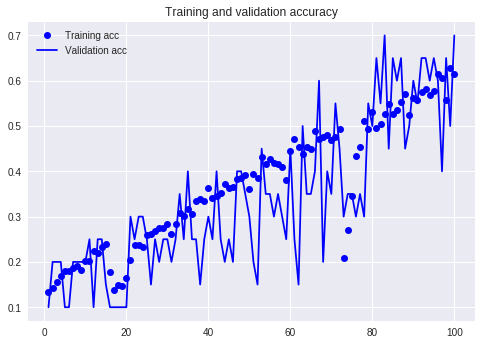

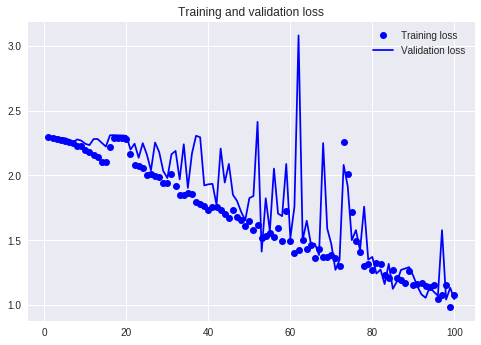

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch=50,
  epochs=100,
  validation_data=validation_generator,
  validation_steps=50)

Epoch 1/100
50/50 [==============================] - 53s 1s/step - loss: 1.0096 - acc: 0.6192 - val_loss: 1.0124 - val_acc: 0.7500
Epoch 2/100
50/50 [==============================] - 51s 1s/step - loss: 0.9456 - acc: 0.6526 - val_loss: 1.2397 - val_acc: 0.5500
Epoch 3/100
50/50 [==============================] - 51s 1s/step - loss: 0.9407 - acc: 0.6443 - val_loss: 1.0175 - val_acc: 0.7500
Epoch 4/100
50/50 [==============================] - 53s 1s/step - loss: 1.0640 - acc: 0.5967 - val_loss: 1.2280 - val_acc: 0.5500
Epoch 5/100
50/50 [==============================] - 51s 1s/step - loss: 0.9303 - acc: 0.6352 - val_loss: 0.9239 - val_acc: 0.7000
Epoch 6/100
13/50 [======>.......................] - ETA: 27s - loss: 1.0251 - acc: 0.6146

50/50 [==============================] - 51s 1s/step - loss: 1.0128 - acc: 0.6163 - val_loss: 1.8284 - val_acc: 0.3000
Epoch 7/100
50/50 [==============================] - 51s 1s/step - loss: 1.0680 - acc: 0.6094 - val_loss: 0.9609 - val_acc: 0.7500
Epoch 8/100
50/50 [==============================] - 52s 1s/step - loss: 0.9547 - acc: 0.6502 - val_loss: 1.0940 - val_acc: 0.5500
Epoch 9/100
50/50 [==============================] - 51s 1s/step - loss: 0.9886 - acc: 0.6243 - val_loss: 0.9747 - val_acc: 0.6500
Epoch 10/100
50/50 [==============================] - 52s 1s/step - loss: 0.8835 - acc: 0.6738 - val_loss: 0.9791 - val_acc: 0.6500
Epoch 11/100
18/50 [=========>....................] - ETA: 25s - loss: 0.9043 - acc: 0.6568

50/50 [==============================] - 51s 1s/step - loss: 0.9161 - acc: 0.6597 - val_loss: 0.8970 - val_acc: 0.7000
Epoch 12/100
50/50 [==============================] - 54s 1s/step - loss: 0.9947 - acc: 0.6474 - val_loss: 0.9555 - val_acc: 0.8000
Epoch 13/100
50/50 [==============================] - 52s 1s/step - loss: 0.8889 - acc: 0.6864 - val_loss: 0.9585 - val_acc: 0.7500
Epoch 14/100
50/50 [==============================] - 52s 1s/step - loss: 0.8978 - acc: 0.6675 - val_loss: 1.0187 - val_acc: 0.8000
Epoch 15/100
50/50 [==============================] - 51s 1s/step - loss: 0.8333 - acc: 0.6889 - val_loss: 0.8641 - val_acc: 0.7500
Epoch 16/100
18/50 [=========>....................] - ETA: 28s - loss: 0.8435 - acc: 0.6910

50/50 [==============================] - 52s 1s/step - loss: 0.8437 - acc: 0.6899 - val_loss: 0.8298 - val_acc: 0.7500
Epoch 17/100
50/50 [==============================] - 50s 993ms/step - loss: 0.8502 - acc: 0.6794 - val_loss: 1.0358 - val_acc: 0.6500
Epoch 18/100
50/50 [==============================] - 50s 1s/step - loss: 1.0820 - acc: 0.6172 - val_loss: 1.2226 - val_acc: 0.5500
Epoch 19/100
50/50 [==============================] - 50s 995ms/step - loss: 0.8463 - acc: 0.6876 - val_loss: 1.0086 - val_acc: 0.6000
Epoch 20/100
50/50 [==============================] - 51s 1s/step - loss: 0.8321 - acc: 0.7082 - val_loss: 0.8317 - val_acc: 0.6000
Epoch 21/100
17/50 [=========>....................] - ETA: 24s - loss: 0.7738 - acc: 0.7200

50/50 [==============================] - 48s 964ms/step - loss: 0.8010 - acc: 0.7173 - val_loss: 0.8171 - val_acc: 0.7500
Epoch 22/100
50/50 [==============================] - 49s 990ms/step - loss: 0.7878 - acc: 0.7042 - val_loss: 0.7000 - val_acc: 0.7500
Epoch 23/100
50/50 [==============================] - 50s 997ms/step - loss: 1.2354 - acc: 0.5563 - val_loss: 1.4167 - val_acc: 0.5000
Epoch 24/100
50/50 [==============================] - 51s 1s/step - loss: 0.9757 - acc: 0.6405 - val_loss: 0.6315 - val_acc: 0.8000
Epoch 25/100
50/50 [==============================] - 50s 992ms/step - loss: 0.8423 - acc: 0.6743 - val_loss: 0.7475 - val_acc: 0.8000
Epoch 26/100
16/50 [========>.....................] - ETA: 25s - loss: 0.7364 - acc: 0.7272

50/50 [==============================] - 48s 966ms/step - loss: 0.7627 - acc: 0.7094 - val_loss: 0.7622 - val_acc: 0.7000
Epoch 27/100
50/50 [==============================] - 49s 985ms/step - loss: 0.9200 - acc: 0.6636 - val_loss: 0.8330 - val_acc: 0.7000
Epoch 28/100
50/50 [==============================] - 50s 1s/step - loss: 0.7644 - acc: 0.7131 - val_loss: 0.7515 - val_acc: 0.7500
Epoch 29/100
50/50 [==============================] - 49s 985ms/step - loss: 0.8216 - acc: 0.6896 - val_loss: 0.7086 - val_acc: 0.8000
Epoch 30/100
50/50 [==============================] - 49s 983ms/step - loss: 0.7155 - acc: 0.7389 - val_loss: 0.6791 - val_acc: 0.8000
Epoch 31/100
16/50 [========>.....................] - ETA: 27s - loss: 0.7332 - acc: 0.7240

50/50 [==============================] - 50s 994ms/step - loss: 0.7014 - acc: 0.7512 - val_loss: 0.8647 - val_acc: 0.7000
Epoch 32/100
50/50 [==============================] - 50s 1s/step - loss: 0.7909 - acc: 0.7054 - val_loss: 0.8414 - val_acc: 0.7500
Epoch 33/100
50/50 [==============================] - 49s 990ms/step - loss: 0.7433 - acc: 0.7272 - val_loss: 0.7207 - val_acc: 0.7500
Epoch 34/100
50/50 [==============================] - 50s 997ms/step - loss: 0.7093 - acc: 0.7435 - val_loss: 0.7938 - val_acc: 0.7500
Epoch 35/100
50/50 [==============================] - 50s 1000ms/step - loss: 0.7335 - acc: 0.7327 - val_loss: 0.7856 - val_acc: 0.8500
Epoch 36/100
16/50 [========>.....................] - ETA: 26s - loss: 0.6074 - acc: 0.7721

50/50 [==============================] - 51s 1s/step - loss: 0.6402 - acc: 0.7578 - val_loss: 0.8163 - val_acc: 0.7500
Epoch 37/100
50/50 [==============================] - 50s 994ms/step - loss: 0.7082 - acc: 0.7379 - val_loss: 1.0818 - val_acc: 0.6000
Epoch 38/100
50/50 [==============================] - 49s 976ms/step - loss: 0.7246 - acc: 0.7413 - val_loss: 0.9303 - val_acc: 0.7000
Epoch 39/100
50/50 [==============================] - 49s 974ms/step - loss: 0.6935 - acc: 0.7426 - val_loss: 0.9379 - val_acc: 0.6500
Epoch 40/100
50/50 [==============================] - 51s 1s/step - loss: 0.6608 - acc: 0.7477 - val_loss: 1.0961 - val_acc: 0.5500
Epoch 41/100
16/50 [========>.....................] - ETA: 24s - loss: 0.8178 - acc: 0.6953

50/50 [==============================] - 49s 987ms/step - loss: 0.7209 - acc: 0.7246 - val_loss: 0.9185 - val_acc: 0.7500
Epoch 42/100
50/50 [==============================] - 49s 987ms/step - loss: 0.6368 - acc: 0.7733 - val_loss: 0.8913 - val_acc: 0.7500
Epoch 43/100
50/50 [==============================] - 49s 988ms/step - loss: 0.6003 - acc: 0.7831 - val_loss: 0.8487 - val_acc: 0.8500
Epoch 44/100
50/50 [==============================] - 50s 1s/step - loss: 0.7207 - acc: 0.7467 - val_loss: 0.8121 - val_acc: 0.7500
Epoch 45/100
50/50 [==============================] - 50s 992ms/step - loss: 0.6666 - acc: 0.7407 - val_loss: 1.4465 - val_acc: 0.6000
Epoch 46/100
16/50 [========>.....................] - ETA: 25s - loss: 3.0462 - acc: 0.1634

50/50 [==============================] - 50s 996ms/step - loss: 1.9175 - acc: 0.3917 - val_loss: 1.2210 - val_acc: 0.5500
Epoch 47/100
50/50 [==============================] - 49s 984ms/step - loss: 0.8268 - acc: 0.6998 - val_loss: 0.6873 - val_acc: 0.8000
Epoch 48/100
50/50 [==============================] - 51s 1s/step - loss: 0.7711 - acc: 0.7152 - val_loss: 0.8775 - val_acc: 0.8500
Epoch 49/100
50/50 [==============================] - 48s 963ms/step - loss: 0.7413 - acc: 0.7259 - val_loss: 0.9154 - val_acc: 0.8500
Epoch 50/100
50/50 [==============================] - 50s 994ms/step - loss: 0.7235 - acc: 0.7388 - val_loss: 0.7480 - val_acc: 0.8000
Epoch 51/100
16/50 [========>.....................] - ETA: 25s - loss: 0.6952 - acc: 0.7402

50/50 [==============================] - 49s 989ms/step - loss: 0.7214 - acc: 0.7469 - val_loss: 0.6870 - val_acc: 0.8000
Epoch 52/100
50/50 [==============================] - 50s 1s/step - loss: 0.7128 - acc: 0.7437 - val_loss: 0.9677 - val_acc: 0.7000
Epoch 53/100
50/50 [==============================] - 49s 983ms/step - loss: 0.6909 - acc: 0.7656 - val_loss: 0.6879 - val_acc: 0.8500
Epoch 54/100
50/50 [==============================] - 48s 960ms/step - loss: 0.6071 - acc: 0.7879 - val_loss: 0.7539 - val_acc: 0.8000
Epoch 55/100
50/50 [==============================] - 49s 988ms/step - loss: 0.9993 - acc: 0.6706 - val_loss: 1.2069 - val_acc: 0.6500
Epoch 56/100
16/50 [========>.....................] - ETA: 26s - loss: 0.7740 - acc: 0.7409

50/50 [==============================] - 51s 1s/step - loss: 0.7169 - acc: 0.7458 - val_loss: 0.7480 - val_acc: 0.8000
Epoch 57/100
50/50 [==============================] - 50s 998ms/step - loss: 0.6389 - acc: 0.7740 - val_loss: 0.7583 - val_acc: 0.8500
Epoch 58/100
50/50 [==============================] - 49s 982ms/step - loss: 0.6583 - acc: 0.7597 - val_loss: 0.7904 - val_acc: 0.8000
Epoch 59/100
50/50 [==============================] - 50s 995ms/step - loss: 0.6218 - acc: 0.7841 - val_loss: 0.7134 - val_acc: 0.7500
Epoch 60/100
50/50 [==============================] - 50s 1s/step - loss: 0.6061 - acc: 0.7807 - val_loss: 0.6270 - val_acc: 0.8000
Epoch 61/100
16/50 [========>.....................] - ETA: 26s - loss: 0.5505 - acc: 0.8001

50/50 [==============================] - 50s 1000ms/step - loss: 0.8124 - acc: 0.7268 - val_loss: 0.8279 - val_acc: 0.8000
Epoch 62/100
50/50 [==============================] - 51s 1s/step - loss: 0.6537 - acc: 0.7479 - val_loss: 0.7161 - val_acc: 0.8000
Epoch 63/100
50/50 [==============================] - 52s 1s/step - loss: 0.5747 - acc: 0.7950 - val_loss: 0.9452 - val_acc: 0.7500
Epoch 64/100
50/50 [==============================] - 53s 1s/step - loss: 0.6135 - acc: 0.7849 - val_loss: 0.6933 - val_acc: 0.7500
Epoch 65/100
50/50 [==============================] - 51s 1s/step - loss: 0.5674 - acc: 0.7858 - val_loss: 0.6161 - val_acc: 0.8000
Epoch 66/100
17/50 [=========>....................] - ETA: 25s - loss: 0.5875 - acc: 0.7855

50/50 [==============================] - 51s 1s/step - loss: 0.5701 - acc: 0.8003 - val_loss: 0.9634 - val_acc: 0.7500
Epoch 67/100
50/50 [==============================] - 50s 1s/step - loss: 0.6307 - acc: 0.7633 - val_loss: 0.7863 - val_acc: 0.7500
Epoch 68/100
50/50 [==============================] - 53s 1s/step - loss: 0.5439 - acc: 0.7996 - val_loss: 0.6477 - val_acc: 0.8000
Epoch 69/100
50/50 [==============================] - 51s 1s/step - loss: 0.5919 - acc: 0.7915 - val_loss: 0.6769 - val_acc: 0.8000
Epoch 70/100
50/50 [==============================] - 51s 1s/step - loss: 0.6020 - acc: 0.7812 - val_loss: 0.8386 - val_acc: 0.7500
Epoch 71/100
18/50 [=========>....................] - ETA: 24s - loss: 0.5194 - acc: 0.8189

50/50 [==============================] - 51s 1s/step - loss: 0.5230 - acc: 0.8156 - val_loss: 0.6806 - val_acc: 0.8000
Epoch 72/100
50/50 [==============================] - 52s 1s/step - loss: 0.5520 - acc: 0.7906 - val_loss: 0.6554 - val_acc: 0.8000
Epoch 73/100
50/50 [==============================] - 50s 1s/step - loss: 0.5975 - acc: 0.7838 - val_loss: 1.0533 - val_acc: 0.8000
Epoch 74/100
50/50 [==============================] - 51s 1s/step - loss: 0.5825 - acc: 0.7894 - val_loss: 0.7678 - val_acc: 0.8000
Epoch 75/100
50/50 [==============================] - 51s 1s/step - loss: 0.5735 - acc: 0.8047 - val_loss: 0.6454 - val_acc: 0.8000
Epoch 76/100
18/50 [=========>....................] - ETA: 26s - loss: 0.4547 - acc: 0.8414

50/50 [==============================] - 53s 1s/step - loss: 0.5013 - acc: 0.8241 - val_loss: 0.7106 - val_acc: 0.7000
Epoch 77/100
50/50 [==============================] - 51s 1s/step - loss: 0.5265 - acc: 0.8203 - val_loss: 0.5699 - val_acc: 0.8000
Epoch 78/100
50/50 [==============================] - 52s 1s/step - loss: 0.4624 - acc: 0.8458 - val_loss: 0.8823 - val_acc: 0.7000
Epoch 79/100
50/50 [==============================] - 51s 1s/step - loss: 0.5177 - acc: 0.8138 - val_loss: 1.2854 - val_acc: 0.6000
Epoch 80/100
50/50 [==============================] - 52s 1s/step - loss: 0.5222 - acc: 0.8143 - val_loss: 0.6123 - val_acc: 0.7500
Epoch 81/100
18/50 [=========>....................] - ETA: 24s - loss: 0.5010 - acc: 0.8079

50/50 [==============================] - 50s 997ms/step - loss: 0.5511 - acc: 0.7970 - val_loss: 0.6805 - val_acc: 0.8000
Epoch 82/100
50/50 [==============================] - 50s 997ms/step - loss: 0.5079 - acc: 0.8289 - val_loss: 0.6145 - val_acc: 0.8000
Epoch 83/100
50/50 [==============================] - 50s 995ms/step - loss: 0.6159 - acc: 0.7873 - val_loss: 0.7803 - val_acc: 0.8000
Epoch 84/100
50/50 [==============================] - 50s 1s/step - loss: 0.4980 - acc: 0.8249 - val_loss: 0.7597 - val_acc: 0.8000
Epoch 85/100
50/50 [==============================] - 49s 989ms/step - loss: 0.4884 - acc: 0.8133 - val_loss: 0.8334 - val_acc: 0.8000
Epoch 86/100
16/50 [========>.....................] - ETA: 25s - loss: 0.6195 - acc: 0.7936

50/50 [==============================] - 49s 971ms/step - loss: 0.5380 - acc: 0.8143 - val_loss: 0.5924 - val_acc: 0.7500
Epoch 87/100
50/50 [==============================] - 49s 989ms/step - loss: 0.4991 - acc: 0.8197 - val_loss: 0.5935 - val_acc: 0.8000
Epoch 88/100
50/50 [==============================] - 51s 1s/step - loss: 0.4755 - acc: 0.8179 - val_loss: 0.6850 - val_acc: 0.8000
Epoch 89/100
50/50 [==============================] - 50s 991ms/step - loss: 0.4436 - acc: 0.8456 - val_loss: 0.8385 - val_acc: 0.7500
Epoch 90/100
50/50 [==============================] - 49s 989ms/step - loss: 0.4412 - acc: 0.8349 - val_loss: 0.8694 - val_acc: 0.7500
Epoch 91/100
16/50 [========>.....................] - ETA: 25s - loss: 0.4346 - acc: 0.8418

50/50 [==============================] - 48s 970ms/step - loss: 0.4136 - acc: 0.8455 - val_loss: 0.6209 - val_acc: 0.8000
Epoch 92/100
50/50 [==============================] - 51s 1s/step - loss: 0.5832 - acc: 0.8031 - val_loss: 0.8035 - val_acc: 0.8000
Epoch 93/100
50/50 [==============================] - 49s 986ms/step - loss: 0.4621 - acc: 0.8197 - val_loss: 0.9169 - val_acc: 0.7500
Epoch 94/100
50/50 [==============================] - 49s 988ms/step - loss: 0.5117 - acc: 0.8152 - val_loss: 0.7039 - val_acc: 0.8000
Epoch 95/100
50/50 [==============================] - 49s 987ms/step - loss: 0.4901 - acc: 0.8206 - val_loss: 0.7848 - val_acc: 0.8000
Epoch 96/100
16/50 [========>.....................] - ETA: 26s - loss: 0.4660 - acc: 0.8366

50/50 [==============================] - 51s 1s/step - loss: 0.4486 - acc: 0.8438 - val_loss: 0.7730 - val_acc: 0.7500
Epoch 97/100
50/50 [==============================] - 49s 975ms/step - loss: 0.4811 - acc: 0.8374 - val_loss: 0.8775 - val_acc: 0.8000
Epoch 98/100
50/50 [==============================] - 50s 992ms/step - loss: 0.4898 - acc: 0.8229 - val_loss: 0.8237 - val_acc: 0.7000
Epoch 99/100
50/50 [==============================] - 49s 975ms/step - loss: 0.4115 - acc: 0.8618 - val_loss: 0.8193 - val_acc: 0.8000
Epoch 100/100
50/50 [==============================] - 51s 1s/step - loss: 0.4225 - acc: 0.8509 - val_loss: 0.8361 - val_acc: 0.8000


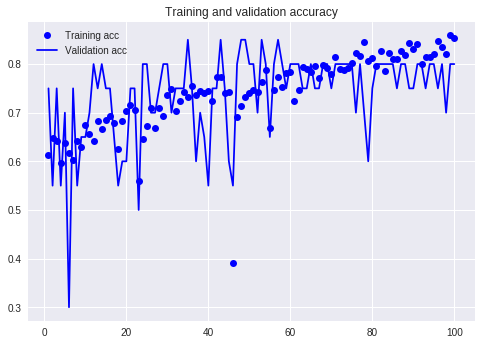

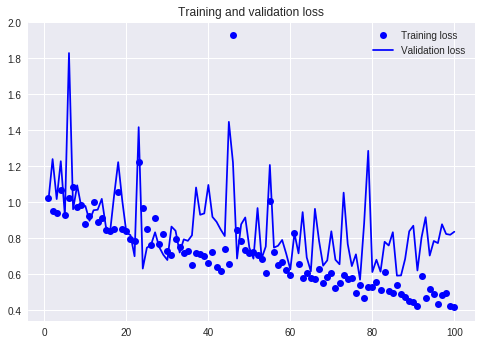

In [13]:
acc_his = [acc]
acc_his.append(history.history['acc'])
val_acc_his = [val_acc]
val_acc_his.append(history.history['val_acc'])
loss_his = [loss]
loss_his.append(history.history['loss'])
val_loss_his = [val_loss]
val_loss_his.append(history.history['val_loss'])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch=50,
  epochs=100,
  validation_data=validation_generator,
  validation_steps=50)

Epoch 1/100
50/50 [==============================] - 49s 972ms/step - loss: 0.5511 - acc: 0.8104 - val_loss: 0.8577 - val_acc: 0.8000
Epoch 2/100
50/50 [==============================] - 48s 956ms/step - loss: 0.4891 - acc: 0.8376 - val_loss: 0.8491 - val_acc: 0.7500
Epoch 3/100
50/50 [==============================] - 47s 946ms/step - loss: 0.4302 - acc: 0.8520 - val_loss: 0.7544 - val_acc: 0.7500
Epoch 4/100
50/50 [==============================] - 49s 970ms/step - loss: 0.4117 - acc: 0.8467 - val_loss: 0.9301 - val_acc: 0.8000
Epoch 5/100
50/50 [==============================] - 47s 934ms/step - loss: 0.4869 - acc: 0.8257 - val_loss: 0.8695 - val_acc: 0.7500
Epoch 6/100
10/50 [=====>........................] - ETA: 32s - loss: 0.3311 - acc: 0.9010

50/50 [==============================] - 48s 950ms/step - loss: 0.4192 - acc: 0.8559 - val_loss: 0.9531 - val_acc: 0.8000
Epoch 7/100
50/50 [==============================] - 47s 944ms/step - loss: 0.4400 - acc: 0.8313 - val_loss: 0.7575 - val_acc: 0.7500
Epoch 8/100
50/50 [==============================] - 49s 980ms/step - loss: 0.4141 - acc: 0.8509 - val_loss: 0.9385 - val_acc: 0.7500
Epoch 9/100
50/50 [==============================] - 48s 953ms/step - loss: 0.3789 - acc: 0.8656 - val_loss: 0.9272 - val_acc: 0.8000
Epoch 10/100
50/50 [==============================] - 47s 946ms/step - loss: 0.3987 - acc: 0.8479 - val_loss: 0.9955 - val_acc: 0.8000
Epoch 11/100
15/50 [========>.....................] - ETA: 27s - loss: 0.4769 - acc: 0.8611

50/50 [==============================] - 47s 935ms/step - loss: 0.4489 - acc: 0.8562 - val_loss: 0.8638 - val_acc: 0.8000
Epoch 12/100
50/50 [==============================] - 49s 980ms/step - loss: 0.4090 - acc: 0.8492 - val_loss: 0.8072 - val_acc: 0.7500
Epoch 13/100
50/50 [==============================] - 47s 948ms/step - loss: 0.4401 - acc: 0.8456 - val_loss: 0.6750 - val_acc: 0.8000
Epoch 14/100
50/50 [==============================] - 47s 949ms/step - loss: 0.3830 - acc: 0.8619 - val_loss: 0.6621 - val_acc: 0.8000
Epoch 15/100
50/50 [==============================] - 46s 925ms/step - loss: 0.3820 - acc: 0.8681 - val_loss: 0.8197 - val_acc: 0.8500
Epoch 16/100
15/50 [========>.....................] - ETA: 28s - loss: 0.4135 - acc: 0.8451

50/50 [==============================] - 49s 972ms/step - loss: 0.4182 - acc: 0.8515 - val_loss: 0.6960 - val_acc: 0.7500
Epoch 17/100
50/50 [==============================] - 48s 960ms/step - loss: 0.4465 - acc: 0.8389 - val_loss: 0.7106 - val_acc: 0.7000
Epoch 18/100
50/50 [==============================] - 50s 992ms/step - loss: 0.3608 - acc: 0.8745 - val_loss: 0.5923 - val_acc: 0.7500
Epoch 19/100
50/50 [==============================] - 47s 933ms/step - loss: 0.4513 - acc: 0.8392 - val_loss: 1.0121 - val_acc: 0.8500
Epoch 20/100
50/50 [==============================] - 49s 972ms/step - loss: 0.3875 - acc: 0.8652 - val_loss: 0.9677 - val_acc: 0.7500
Epoch 21/100
15/50 [========>.....................] - ETA: 25s - loss: 0.4821 - acc: 0.8236

50/50 [==============================] - 48s 953ms/step - loss: 0.3919 - acc: 0.8533 - val_loss: 0.6671 - val_acc: 0.8000
Epoch 22/100
50/50 [==============================] - 48s 958ms/step - loss: 0.3448 - acc: 0.8856 - val_loss: 0.6158 - val_acc: 0.8000
Epoch 23/100
50/50 [==============================] - 47s 944ms/step - loss: 0.4422 - acc: 0.8562 - val_loss: 0.7733 - val_acc: 0.8000
Epoch 24/100
50/50 [==============================] - 47s 950ms/step - loss: 0.3699 - acc: 0.8789 - val_loss: 0.7019 - val_acc: 0.8000
Epoch 25/100
50/50 [==============================] - 48s 951ms/step - loss: 0.3238 - acc: 0.8821 - val_loss: 0.8384 - val_acc: 0.8000
Epoch 26/100
15/50 [========>.....................] - ETA: 25s - loss: 0.4531 - acc: 0.8465

50/50 [==============================] - 48s 965ms/step - loss: 0.3878 - acc: 0.8698 - val_loss: 0.5967 - val_acc: 0.7500
Epoch 27/100
50/50 [==============================] - 47s 943ms/step - loss: 0.4018 - acc: 0.8577 - val_loss: 0.5897 - val_acc: 0.8500
Epoch 28/100
50/50 [==============================] - 49s 974ms/step - loss: 0.3471 - acc: 0.8790 - val_loss: 0.7146 - val_acc: 0.7500
Epoch 29/100
50/50 [==============================] - 47s 942ms/step - loss: 0.3691 - acc: 0.8756 - val_loss: 0.5532 - val_acc: 0.8000
Epoch 30/100
50/50 [==============================] - 48s 958ms/step - loss: 0.3632 - acc: 0.8637 - val_loss: 0.6780 - val_acc: 0.7500
Epoch 31/100
15/50 [========>.....................] - ETA: 25s - loss: 0.2879 - acc: 0.8917

50/50 [==============================] - 47s 942ms/step - loss: 0.3435 - acc: 0.8761 - val_loss: 0.6835 - val_acc: 0.8000
Epoch 32/100
50/50 [==============================] - 49s 979ms/step - loss: 0.3781 - acc: 0.8615 - val_loss: 0.6938 - val_acc: 0.8000
Epoch 33/100
50/50 [==============================] - 48s 966ms/step - loss: 0.3489 - acc: 0.8712 - val_loss: 0.8841 - val_acc: 0.7500
Epoch 34/100
50/50 [==============================] - 47s 935ms/step - loss: 0.3473 - acc: 0.8734 - val_loss: 0.8164 - val_acc: 0.7500
Epoch 35/100
50/50 [==============================] - 48s 952ms/step - loss: 0.4338 - acc: 0.8513 - val_loss: 0.8479 - val_acc: 0.7500
Epoch 36/100
15/50 [========>.....................] - ETA: 26s - loss: 0.3956 - acc: 0.8389

50/50 [==============================] - 49s 979ms/step - loss: 0.3286 - acc: 0.8690 - val_loss: 0.6479 - val_acc: 0.8000
Epoch 37/100
50/50 [==============================] - 48s 956ms/step - loss: 0.3721 - acc: 0.8739 - val_loss: 1.0127 - val_acc: 0.8000
Epoch 38/100
50/50 [==============================] - 48s 966ms/step - loss: 0.3652 - acc: 0.8675 - val_loss: 0.4462 - val_acc: 0.8000
Epoch 39/100
50/50 [==============================] - 47s 946ms/step - loss: 0.3109 - acc: 0.8891 - val_loss: 0.8434 - val_acc: 0.8000
Epoch 40/100
50/50 [==============================] - 50s 991ms/step - loss: 0.3412 - acc: 0.8808 - val_loss: 0.7655 - val_acc: 0.7500
Epoch 41/100
15/50 [========>.....................] - ETA: 26s - loss: 0.3582 - acc: 0.8660

50/50 [==============================] - 49s 982ms/step - loss: 0.3169 - acc: 0.8875 - val_loss: 0.6750 - val_acc: 0.7500
Epoch 42/100
50/50 [==============================] - 49s 970ms/step - loss: 0.3098 - acc: 0.8929 - val_loss: 0.6380 - val_acc: 0.8000
Epoch 43/100
50/50 [==============================] - 50s 993ms/step - loss: 0.3611 - acc: 0.8725 - val_loss: 0.7689 - val_acc: 0.8000
Epoch 44/100
50/50 [==============================] - 50s 1s/step - loss: 0.2898 - acc: 0.8938 - val_loss: 0.7918 - val_acc: 0.8500
Epoch 45/100
50/50 [==============================] - 50s 1s/step - loss: 0.2933 - acc: 0.8883 - val_loss: 0.4952 - val_acc: 0.8000
Epoch 46/100
16/50 [========>.....................] - ETA: 24s - loss: 0.3078 - acc: 0.8952

50/50 [==============================] - 50s 997ms/step - loss: 0.3177 - acc: 0.8813 - val_loss: 0.8710 - val_acc: 0.8000
Epoch 47/100
50/50 [==============================] - 49s 987ms/step - loss: 0.2978 - acc: 0.8871 - val_loss: 0.8634 - val_acc: 0.8000
Epoch 48/100
50/50 [==============================] - 51s 1s/step - loss: 0.3509 - acc: 0.8731 - val_loss: 1.1661 - val_acc: 0.7500
Epoch 49/100
50/50 [==============================] - 50s 995ms/step - loss: 0.3065 - acc: 0.8877 - val_loss: 0.8341 - val_acc: 0.8000
Epoch 50/100
50/50 [==============================] - 49s 977ms/step - loss: 0.3130 - acc: 0.8935 - val_loss: 0.5180 - val_acc: 0.8000
Epoch 51/100
16/50 [========>.....................] - ETA: 27s - loss: 0.3472 - acc: 0.8952

50/50 [==============================] - 50s 991ms/step - loss: 0.3116 - acc: 0.8925 - val_loss: 0.8588 - val_acc: 0.8000
Epoch 52/100
50/50 [==============================] - 51s 1s/step - loss: 0.3379 - acc: 0.8838 - val_loss: 0.8968 - val_acc: 0.8500
Epoch 53/100
50/50 [==============================] - 50s 1s/step - loss: 0.3324 - acc: 0.8748 - val_loss: 0.8940 - val_acc: 0.8000
Epoch 54/100
50/50 [==============================] - 50s 998ms/step - loss: 0.3370 - acc: 0.8848 - val_loss: 0.6572 - val_acc: 0.8000
Epoch 55/100
50/50 [==============================] - 49s 986ms/step - loss: 0.2992 - acc: 0.8858 - val_loss: 0.9881 - val_acc: 0.8000
Epoch 56/100
17/50 [=========>....................] - ETA: 26s - loss: 0.2898 - acc: 0.8995

50/50 [==============================] - 50s 1s/step - loss: 0.3397 - acc: 0.8770 - val_loss: 0.9722 - val_acc: 0.8000
Epoch 57/100
50/50 [==============================] - 50s 993ms/step - loss: 0.2658 - acc: 0.8995 - val_loss: 0.9961 - val_acc: 0.8500
Epoch 58/100
50/50 [==============================] - 49s 987ms/step - loss: 0.3176 - acc: 0.8838 - val_loss: 1.0238 - val_acc: 0.8000
Epoch 59/100
50/50 [==============================] - 50s 992ms/step - loss: 0.2878 - acc: 0.8971 - val_loss: 0.9063 - val_acc: 0.8500
Epoch 60/100
50/50 [==============================] - 51s 1s/step - loss: 0.2982 - acc: 0.8977 - val_loss: 0.9906 - val_acc: 0.8500
Epoch 61/100
16/50 [========>.....................] - ETA: 24s - loss: 0.2325 - acc: 0.9056

50/50 [==============================] - 50s 994ms/step - loss: 0.5046 - acc: 0.8500 - val_loss: 0.7366 - val_acc: 0.8000
Epoch 62/100
50/50 [==============================] - 50s 1s/step - loss: 0.2542 - acc: 0.9063 - val_loss: 0.8492 - val_acc: 0.8000
Epoch 63/100
50/50 [==============================] - 50s 995ms/step - loss: 0.2779 - acc: 0.9061 - val_loss: 0.7686 - val_acc: 0.8000
Epoch 64/100
50/50 [==============================] - 52s 1s/step - loss: 0.2950 - acc: 0.9015 - val_loss: 0.8810 - val_acc: 0.7500
Epoch 65/100
50/50 [==============================] - 51s 1s/step - loss: 0.2992 - acc: 0.8907 - val_loss: 0.7214 - val_acc: 0.7500
Epoch 66/100
16/50 [========>.....................] - ETA: 25s - loss: 0.2760 - acc: 0.9004

50/50 [==============================] - 49s 987ms/step - loss: 0.2642 - acc: 0.8987 - val_loss: 0.9548 - val_acc: 0.8000
Epoch 67/100
50/50 [==============================] - 49s 976ms/step - loss: 0.2593 - acc: 0.9082 - val_loss: 1.0774 - val_acc: 0.8000
Epoch 68/100
50/50 [==============================] - 51s 1s/step - loss: 0.2865 - acc: 0.8979 - val_loss: 0.8092 - val_acc: 0.7500
Epoch 69/100
50/50 [==============================] - 50s 1000ms/step - loss: 0.2634 - acc: 0.9075 - val_loss: 0.8700 - val_acc: 0.7500
Epoch 70/100
50/50 [==============================] - 51s 1s/step - loss: 0.2578 - acc: 0.9073 - val_loss: 0.7851 - val_acc: 0.7500
Epoch 71/100
16/50 [========>.....................] - ETA: 26s - loss: 0.3218 - acc: 0.8867

50/50 [==============================] - 49s 989ms/step - loss: 0.2779 - acc: 0.8914 - val_loss: 0.8370 - val_acc: 0.7500
Epoch 72/100
50/50 [==============================] - 51s 1s/step - loss: 0.2607 - acc: 0.9052 - val_loss: 0.7947 - val_acc: 0.8000
Epoch 73/100
50/50 [==============================] - 50s 995ms/step - loss: 0.2352 - acc: 0.9158 - val_loss: 0.6064 - val_acc: 0.8500
Epoch 74/100
50/50 [==============================] - 49s 989ms/step - loss: 0.6342 - acc: 0.8344 - val_loss: 0.7615 - val_acc: 0.7500
Epoch 75/100
50/50 [==============================] - 50s 993ms/step - loss: 0.3136 - acc: 0.8967 - val_loss: 1.0674 - val_acc: 0.8000
Epoch 76/100
16/50 [========>.....................] - ETA: 27s - loss: 0.3869 - acc: 0.8828

50/50 [==============================] - 51s 1s/step - loss: 0.3282 - acc: 0.8845 - val_loss: 0.6869 - val_acc: 0.8000
Epoch 77/100
50/50 [==============================] - 49s 979ms/step - loss: 0.2437 - acc: 0.9088 - val_loss: 0.7877 - val_acc: 0.7500
Epoch 78/100
50/50 [==============================] - 48s 967ms/step - loss: 0.2180 - acc: 0.9215 - val_loss: 0.9271 - val_acc: 0.8000
Epoch 79/100
50/50 [==============================] - 47s 935ms/step - loss: 0.3063 - acc: 0.9003 - val_loss: 1.0015 - val_acc: 0.8500
Epoch 80/100
50/50 [==============================] - 49s 986ms/step - loss: 0.2704 - acc: 0.9087 - val_loss: 0.9188 - val_acc: 0.8000
Epoch 81/100
16/50 [========>.....................] - ETA: 24s - loss: 0.2095 - acc: 0.9316

50/50 [==============================] - 48s 965ms/step - loss: 0.2399 - acc: 0.9203 - val_loss: 0.8852 - val_acc: 0.7500
Epoch 82/100
50/50 [==============================] - 48s 968ms/step - loss: 0.2196 - acc: 0.9216 - val_loss: 0.7347 - val_acc: 0.8500
Epoch 83/100
50/50 [==============================] - 49s 971ms/step - loss: 0.2812 - acc: 0.8969 - val_loss: 0.6571 - val_acc: 0.8000
Epoch 84/100
50/50 [==============================] - 49s 982ms/step - loss: 0.2271 - acc: 0.9092 - val_loss: 0.9517 - val_acc: 0.7500
Epoch 85/100
50/50 [==============================] - 49s 974ms/step - loss: 0.3195 - acc: 0.9029 - val_loss: 0.8293 - val_acc: 0.7500
Epoch 86/100
15/50 [========>.....................] - ETA: 26s - loss: 0.2603 - acc: 0.9125

50/50 [==============================] - 48s 968ms/step - loss: 0.3029 - acc: 0.8952 - val_loss: 0.7863 - val_acc: 0.8000
Epoch 87/100
50/50 [==============================] - 49s 982ms/step - loss: 0.2704 - acc: 0.9119 - val_loss: 1.0347 - val_acc: 0.8000
Epoch 88/100
50/50 [==============================] - 51s 1s/step - loss: 0.2402 - acc: 0.9131 - val_loss: 0.8649 - val_acc: 0.8000
Epoch 89/100
50/50 [==============================] - 49s 983ms/step - loss: 0.2096 - acc: 0.9262 - val_loss: 0.8301 - val_acc: 0.8000
Epoch 90/100
50/50 [==============================] - 51s 1s/step - loss: 0.2176 - acc: 0.9208 - val_loss: 0.8776 - val_acc: 0.8000
Epoch 91/100
16/50 [========>.....................] - ETA: 26s - loss: 0.2765 - acc: 0.8835

50/50 [==============================] - 49s 989ms/step - loss: 0.2779 - acc: 0.8964 - val_loss: 0.8807 - val_acc: 0.8500
Epoch 92/100
50/50 [==============================] - 51s 1s/step - loss: 0.2753 - acc: 0.9031 - val_loss: 0.7805 - val_acc: 0.8500
Epoch 93/100
50/50 [==============================] - 49s 989ms/step - loss: 0.2398 - acc: 0.9146 - val_loss: 0.6139 - val_acc: 0.8000
Epoch 94/100
50/50 [==============================] - 50s 1s/step - loss: 0.2268 - acc: 0.9183 - val_loss: 0.5658 - val_acc: 0.8500
Epoch 95/100
50/50 [==============================] - 48s 968ms/step - loss: 0.2420 - acc: 0.9156 - val_loss: 0.8432 - val_acc: 0.8500
Epoch 96/100
16/50 [========>.....................] - ETA: 28s - loss: 0.2443 - acc: 0.9206

50/50 [==============================] - 51s 1s/step - loss: 0.2244 - acc: 0.9181 - val_loss: 0.8286 - val_acc: 0.8000
Epoch 97/100
50/50 [==============================] - 50s 997ms/step - loss: 0.2802 - acc: 0.9090 - val_loss: 0.9493 - val_acc: 0.8500
Epoch 98/100
50/50 [==============================] - 49s 984ms/step - loss: 0.2250 - acc: 0.9212 - val_loss: 0.7255 - val_acc: 0.8500
Epoch 99/100
50/50 [==============================] - 49s 983ms/step - loss: 0.2207 - acc: 0.9185 - val_loss: 1.1447 - val_acc: 0.7500
Epoch 100/100
50/50 [==============================] - 51s 1s/step - loss: 0.2554 - acc: 0.9176 - val_loss: 0.6974 - val_acc: 0.8500


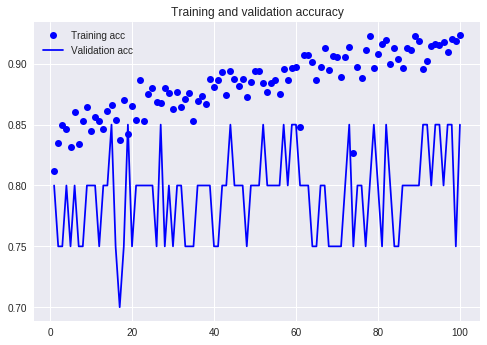

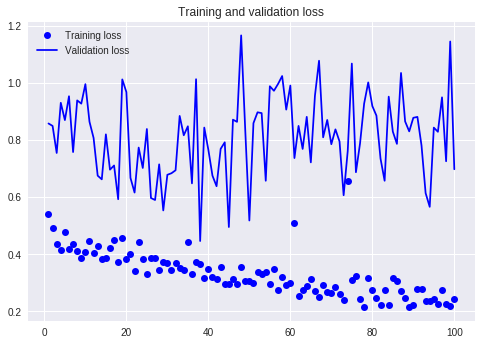

In [15]:
acc_his.append(history.history['acc'])
val_acc_his.append(history.history['val_acc'])
loss_his.append(history.history['loss'])
val_loss_his.append(history.history['val_loss'])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()            

In [28]:
# val_loss = [a for a in val_loss_his[0]]
# val_loss.extend(val_loss_his[1])
len(val_loss_his)

1

In [0]:
model.save('./drive/data/model/vanilla_drop.h5')                  
